# An introductional notebook to HEP analysis in C++

<p>In this notebook you can find an easy set of commands that show some basic computing techniques commonly used in High Energy Physics (HEP) analyzes.</p>

<p>It also shows how to create an histogram, fill it and draw it. Moreover it is an introduction to [ROOT](https://root.cern.ch/) too. The final output is a plot with the number of leptons.</p>

Based on ATLAS opendata notebooks (http://opendata.atlas.cern/release/2020/documentation/notebooks/intro.html)


The library used is [ROOT](https://root.cern.ch/), a scientific data analysis software framework that provides a large set of functionalities needed to deal with big data processing, statistical analysis, visualisation and storage.

<p>At first we have to include several helpers that will support our analysis:</p>

In [1]:
#include <iostream>
#include <string>
#include <stdio.h>
#include <time.h>

Next we have to open the data that we want to analyze. As described above the data is stored in a _*.root_ file. This is a root file containing tracks and calorimeter clusters

In [2]:
TFile *file = TFile::Open("ttbar_8TeV.root"); 

The next step is to define a tree named _tree_ to get the data out of the _*.root_ file. The tree in this root file is called "mini". We will then print the contents of the tree to find the names of the variables. 

In [3]:
TTree *tree = (TTree*) file->Get("mini");
tree->Print()

******************************************************************************
*Tree    :mini      : 4-vectors + variables required for scaling factors     *
*Entries :  1500000 : Total =       567791759 bytes  File  Size =  300057248 *
*        :          : Tree compression factor =   1.89                       *
******************************************************************************
*Br    0 :runNumber : runNumber/I                                            *
*Entries :  1500000 : Total  Size=    6002049 bytes  File Size  =      31136 *
*Baskets :       18 : Basket Size=     790016 bytes  Compression= 192.75     *
*............................................................................*
*Br    1 :eventNumber : eventNumber/I                                        *
*Entries :  1500000 : Total  Size=    6002093 bytes  File Size  =    3819950 *
*Baskets :       18 : Basket Size=     790016 bytes  Compression=   1.57     *
*...................................................

Activate variables 

In [4]:
Int_t MC_runNumber = -1;

Bool_t e_trig;
Bool_t mu_trig;
Bool_t good_vtx;
UInt_t lep_n;
UInt_t jet_n;
Float_t MET;
Float_t MET_phi;

Float_t lep_pt[10];  
Float_t lep_eta[10];  
Float_t lep_phi[10];  
Float_t lep_E[10];  
Int_t lep_type[10];  
Float_t lep_ptcone30[10];
Float_t lep_etcone20[10];

Float_t jet_pt[10]; 
Float_t jet_eta[10];
Float_t jet_jvf[10];
Float_t jet_mv1[10];

float evtw = -1;

Float_t scaleFactor_PILEUP;
Float_t scaleFactor_ELE;
Float_t scaleFactor_MUON;
Float_t scaleFactor_BTAG;
Float_t scaleFactor_TRIGGER;
Float_t scaleFactor_JVFSF;
Float_t scaleFactor_ZVERTEX;

tree->SetBranchAddress("trigE", &e_trig);
tree->SetBranchAddress("trigM", &mu_trig);
tree->SetBranchAddress("hasGoodVertex", &good_vtx);
tree->SetBranchAddress("lep_n", &lep_n);
tree->SetBranchAddress("jet_n", &jet_n);
tree->SetBranchAddress("met_et", &MET);
tree->SetBranchAddress("met_phi", &MET_phi);

tree->SetBranchAddress("lep_pt", &lep_pt);
tree->SetBranchAddress("lep_eta", &lep_eta);
tree->SetBranchAddress("lep_phi", &lep_phi);
tree->SetBranchAddress("lep_E", &lep_E);
tree->SetBranchAddress("lep_type", &lep_type);
tree->SetBranchAddress("lep_ptcone30", &lep_ptcone30);
tree->SetBranchAddress("lep_etcone20", &lep_etcone20);

tree->SetBranchAddress("jet_pt", &jet_pt);
tree->SetBranchAddress("jet_eta", &jet_eta);
tree->SetBranchAddress("jet_jvf", &jet_jvf);
tree->SetBranchAddress("jet_MV1", &jet_mv1);

tree->SetBranchAddress("mcWeight", &evtw);
tree->SetBranchAddress("runNumber", &MC_runNumber);

tree->SetBranchAddress("scaleFactor_PILEUP", &scaleFactor_PILEUP);
tree->SetBranchAddress("scaleFactor_ELE", &scaleFactor_ELE);
tree->SetBranchAddress("scaleFactor_MUON", &scaleFactor_MUON);
tree->SetBranchAddress("scaleFactor_BTAG", &scaleFactor_BTAG);
tree->SetBranchAddress("scaleFactor_TRIGGER", &scaleFactor_TRIGGER);
tree->SetBranchAddress("scaleFactor_JVFSF", &scaleFactor_JVFSF);
tree->SetBranchAddress("scaleFactor_ZVERTEX", &scaleFactor_ZVERTEX);

Create Canvas

In [5]:
TCanvas *canvas = new TCanvas("Canvas","",800,600);

Create histograms: Leading jet pT and all jets pT 

In [6]:
TH1F *cutflow = new TH1F("Cutflow","Cutflow; Cut; Events",10,0,10);

TH1F *hist_njets = new TH1F("Number of jets","n-jets; Jet multiplicity; Events",10,0,10);


# Graficos

In [7]:
// Leptons
TH1F *hist_lep_pt = new TH1F("Lepton pT","Lepton pT; pT (GeV); Events",20,1000,100000);
TH1F *hist_lep_ptcone30 = new TH1F("Lepton ptcone30","Lepton ptcone30; ptcone30; Events",20,0,5);
TH1F *hist_lep_etcone20 = new TH1F("Lepton etcone20","Lepton etcone20; etcone20; Events",20,-1,1);
TH1F *hist_lep_eta = new TH1F("Lepton eta","Lepton eta; eta (GeV); Events",20,-5,5);
// Jets
TH1F *hist_jets_pt = new TH1F("Jets pT","Jets pT; pT (GeV); Events",20,0,1000000);
TH1F *hist_jets_eta = new TH1F("Jets eta","Jets eta; eta (rad); Events",20,-5,5);
TH1F *hist_jets_JVF = new TH1F("Jets JVF","Jets JVF; JVF; Events",50,0,1);
TH1F *hist_jets_MV1 = new TH1F("Jets MV1 output","Jets MV1 output; MV1 output; Events",10,0,1);
// B-Jets
TH1F *hist_n_bjets = new TH1F("Number b-Jets ","Number of b-Jets MV1 output; Number of b-Jets; Events",200,0,10);
// MET
TH1F *hist_MET = new TH1F("MET ","MET; MET; Events",200,0,100000);
// mT(W)
TH1F *hist_MTW = new TH1F("mT(w) ","mT(W); mT(w); Events",200,0,100000);

Loop and fill histograms

In [8]:
int nentries, nbytes, i;
nentries = (Int_t)tree->GetEntries();

Float_t scaleFactor = scaleFactor_ELE*scaleFactor_MUON*scaleFactor_TRIGGER*scaleFactor_PILEUP*scaleFactor_ZVERTEX;
Float_t ectw = scaleFactor*evtw;

int cut1 = 0;
int cut2 = 0;
int cut3 = 0;
int cut4 = 0;
int cut5 = 0;
int cut6 = 0;
int cut7 = 0;
int cut8 = 0;


for (i = 0; i < nentries; i++)
{
    nbytes = tree->GetEntry(i);   

    //First cut: Good vertex
    if(!good_vtx) continue;
    cut1++;
    cutflow->Fill(1);

    //Second cut: Trigger
    if(!e_trig && !mu_trig) continue;
    cut2++;
    cutflow->Fill(2);
        
    // Preselection of good leptons                                                                                
    int n_mu=0;
    int n_el=0;
    int n_lep=0;
    int good_lep=0;
  
    //Loop over leptons
    for(unsigned int i=0; i<lep_n; i++){
        
        if( lep_pt[i] < 25000.) continue; 
        if( lep_ptcone30[i]/lep_pt[i] > 0.15 ) continue; 
        if( lep_etcone20[i]/lep_pt[i] > 0.15 ) continue;  
        if( lep_type [i]==13 && TMath::Abs(lep_eta[i]) < 2.5 ){
            n_mu++;
            good_lep=i;}
        
        /*
        To complete: Add electrons and extract the index for the good lepton
        */
        if( lep_type [i]==11 && TMath::Abs(lep_eta[i]) < 2.47) { 
            if(TMath::Abs(lep_eta[i]) < 1.37 || TMath::Abs(lep_eta[i]) > 1.52 ){
                n_el++;
                good_lep=i;}}
        hist_lep_pt->Fill(lep_pt[i]);
        hist_lep_ptcone30->Fill(lep_ptcone30[i]/lep_pt[i],ectw);
        hist_lep_etcone20->Fill(lep_etcone20[i]/lep_pt[i],ectw);
        hist_lep_eta->Fill(lep_eta[i],ectw);
        
    }
    n_lep = n_mu + n_el;
    
     //Select events with only 1 good lepton and fill the cutflow histogram 
    //Example:
    //Third cut (one good lepton):
    if(n_lep!=1) continue;
    cutflow->Fill(3); 
    cut3++;
  
    
    int n_jets=0;
    int n_bjets=0;
    
    //Number of jets distribution
   

                                                                                                                                               //Fourth cut: At least 4 jets
    if(jet_n<4) continue; 
    cutflow->Fill(4); 
    cut4++;

    for(unsigned int j=0; j<jet_n; j++){
        // Histograms
        
        // To complete: apply jet cuts to find the good jets
        if(jet_pt[j] < 25000.) continue;
        //Eta cut
        if(TMath::Abs(jet_eta[j]) > 2.5) continue;
        // JVF cleaning         
        if(jet_pt[j] < 50000 && TMath::Abs(jet_eta[j])<2.4 && jet_jvf[j]<0.5)continue;
        n_jets++;
        // cut on 0.7892 MV1 and count the number of b-jets
        if(TMath::Abs(jet_mv1[j]) < 0.7892) continue;
        n_bjets++;
        hist_jets_pt->Fill(jet_pt[j],ectw);
        hist_jets_eta->Fill(jet_eta[j],ectw);
        hist_jets_JVF->Fill(jet_jvf[j],ectw);
        hist_jets_MV1->Fill(jet_mv1[j],ectw);
        }
    
    //Fifth cut: At least 4 good jets
    if(n_jets<4) continue; 
    cutflow->Fill(5); 
    cut5++;
     hist_njets->Fill(jet_n,ectw);
    
    //Sixth cut: at least one b-jet
    if(n_bjets<2) continue;
    cutflow->Fill(6);
    cut6++;
    hist_n_bjets->Fill(n_bjets,ectw);
    
    //Seventh cut: MET > 30 GeV
    if(MET<30000.) continue;
    cutflow->Fill(7);
    cut7++;
    hist_MET->Fill(MET,ectw);
    // TLorentzVector definitions                                                               
    TLorentzVector Lepton  = TLorentzVector();
    TLorentzVector  MeT  = TLorentzVector();

    //To complete: Lorentz vectors for the lepton and MET. Use SetPtEtaPhiE().
    Lepton.SetPtEtaPhiE(lep_pt[good_lep],lep_eta[good_lep],lep_phi[good_lep],lep_E[good_lep]);
    MeT.SetPtEtaPhiE(MET,0,MET_phi,MET);
    //Calculation of the mTW using TLorentz vectors    
    float mTW = sqrt(2*Lepton.Pt()*MeT.Et()*(1-cos(Lepton.DeltaPhi(MeT))));

    
    //Eight cut: mTW > 30 GeV
    if(mTW>30000){
        cutflow->Fill(8);
        cut8++;
    hist_MTW->Fill(mTW,ectw);
    }
}

std::cout << "Done!" << std::endl;
std::cout << "All events:" << nentries << std::endl;
std::cout << "Cut1:" << cut1 << std::endl;
std::cout << "Cut2:" << cut2 << std::endl;
std::cout << "Cut3:" << cut3 << std::endl;
std::cout << "Cut4:" << cut4 << std::endl;
std::cout << "Cut5:" << cut5 << std::endl;
std::cout << "Cut6:" << cut6 << std::endl;
std::cout << "Cut7:" << cut7 << std::endl;
std::cout << "Cut8:" << cut8 << std::endl;



Done!
All events:1500000
Cut1:1499487
Cut2:1499487
Cut3:1336214
Cut4:623273
Cut5:622125
Cut6:259904
Cut7:214514
Cut8:180967


<p>Draw</p>

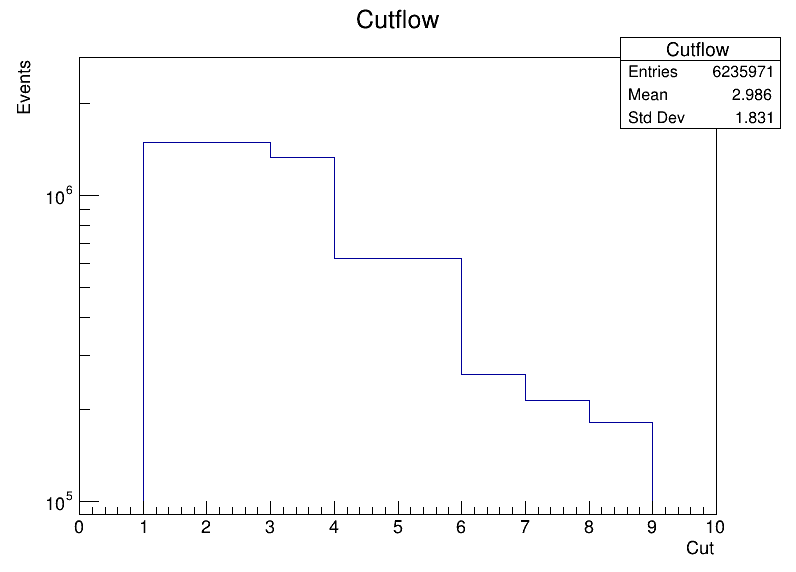

In [12]:
cutflow->Draw("");
canvas->SetLogy();
canvas->Draw();

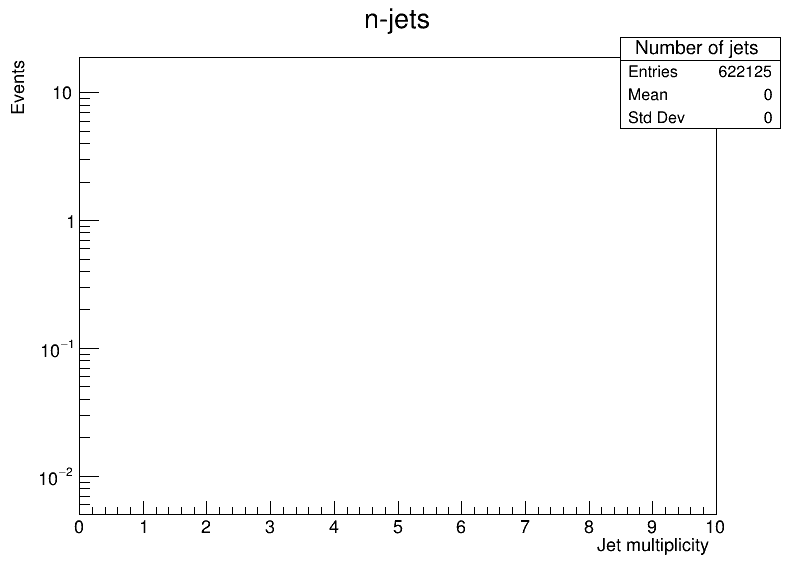

In [9]:
hist_njets->Draw();
canvas->SetLogy();
canvas->Draw();

# Lepton

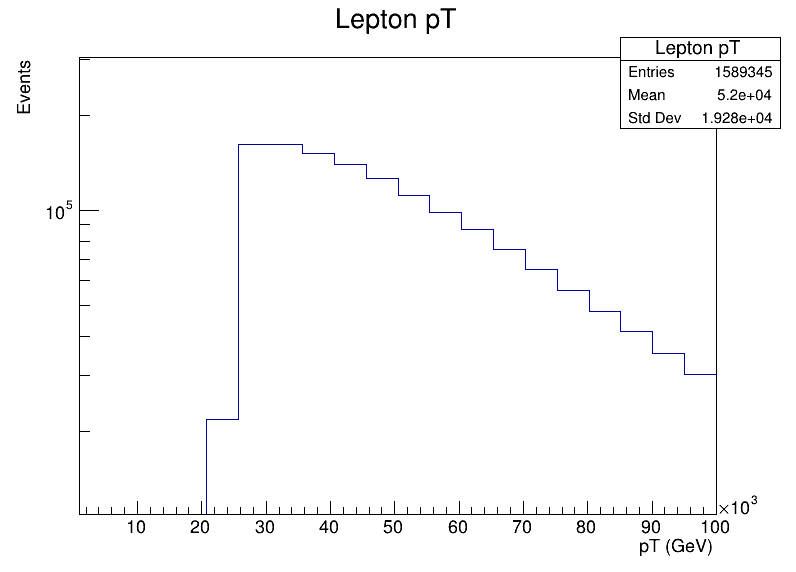

In [14]:
hist_lep_pt->Draw();
canvas->SetLogy();
canvas->Draw();

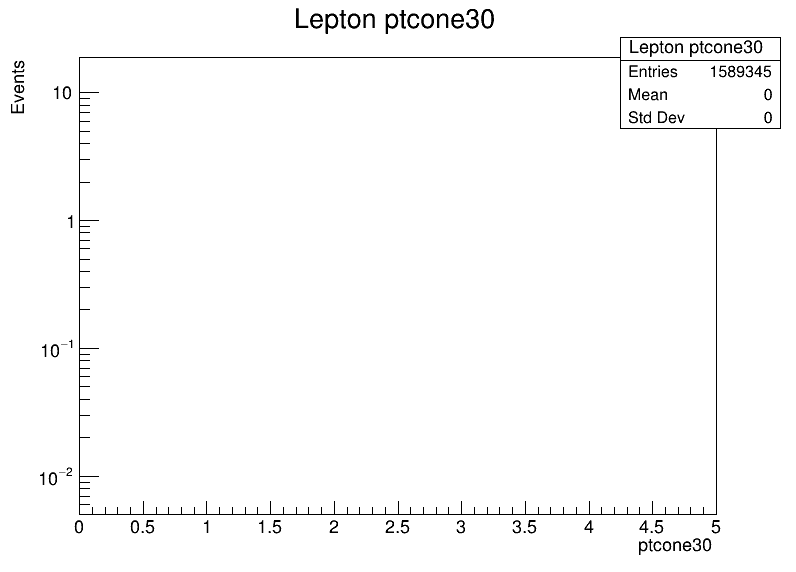

In [10]:
hist_lep_ptcone30->Draw();
canvas->SetLogy();
canvas->Draw();

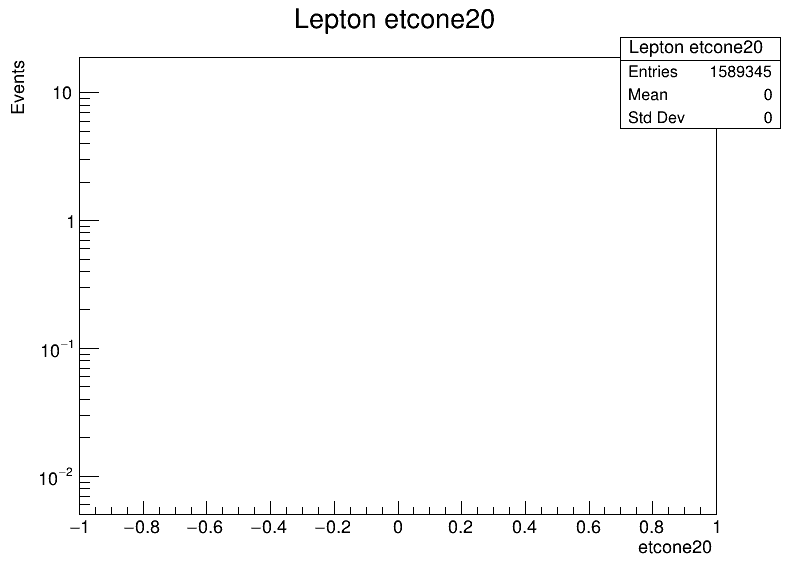

In [11]:
hist_lep_etcone20->Draw();
canvas->SetLogy();
canvas->Draw();

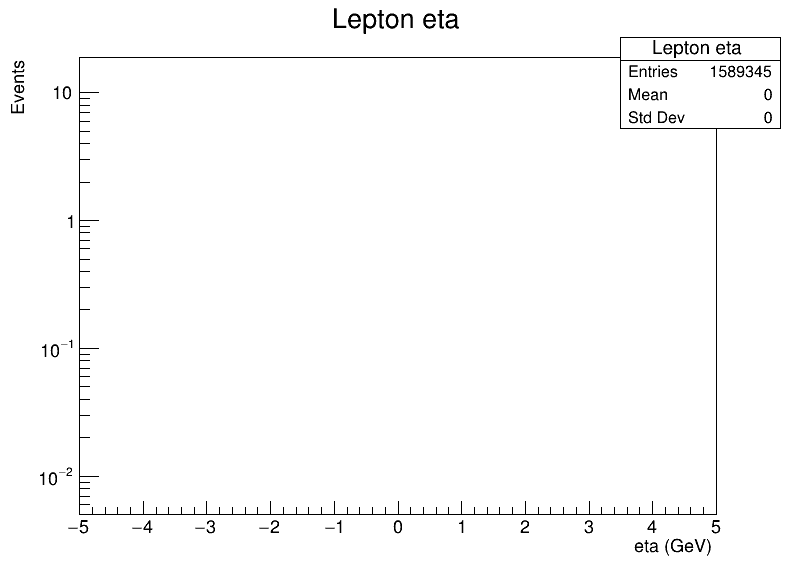

In [12]:
hist_lep_eta->Draw();
canvas->Draw();

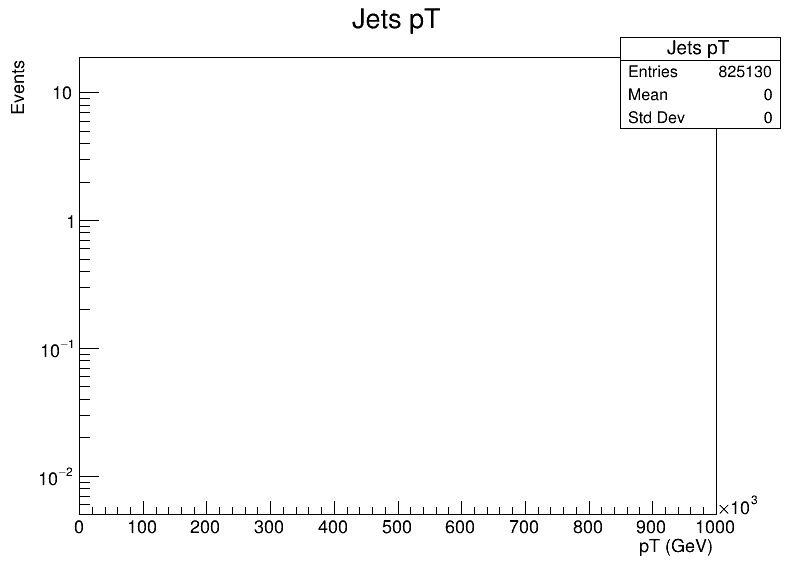

In [13]:
hist_jets_pt->Draw();
canvas->SetLogy();
canvas->Draw();

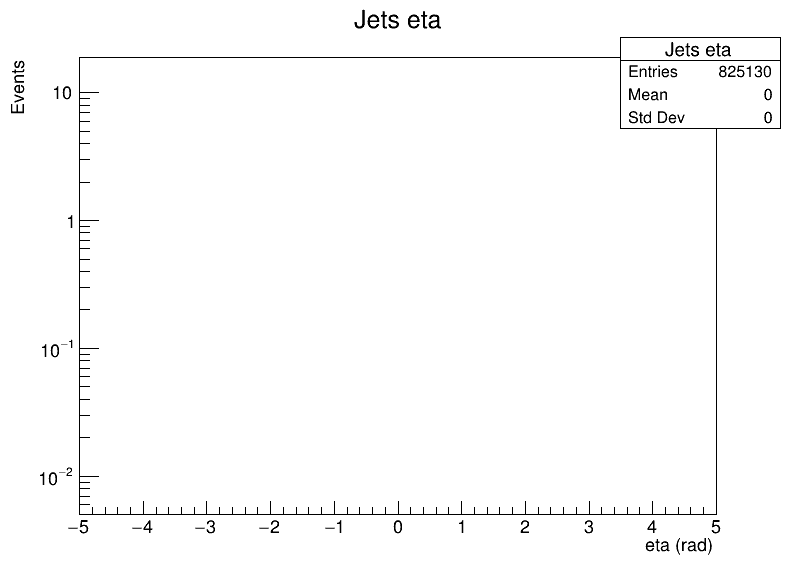

In [14]:
hist_jets_eta->Draw();
canvas->Draw();

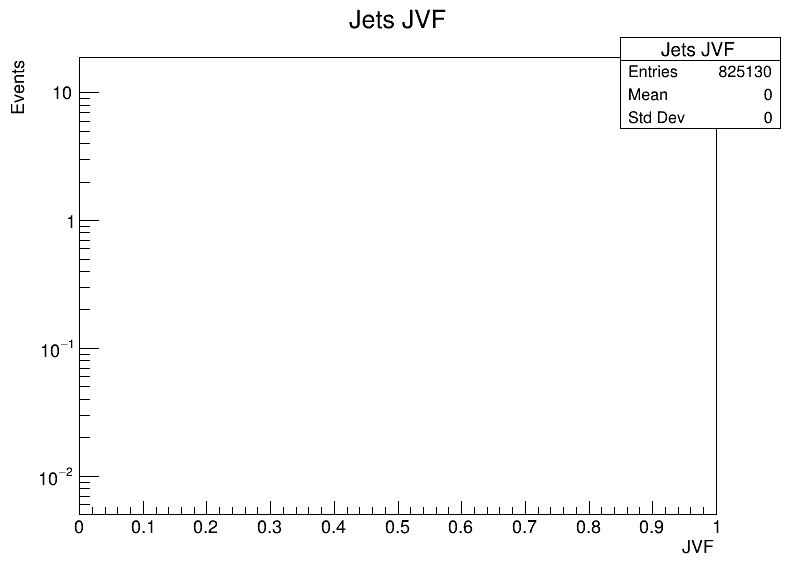

In [15]:
hist_jets_JVF->Draw();
canvas->Draw();

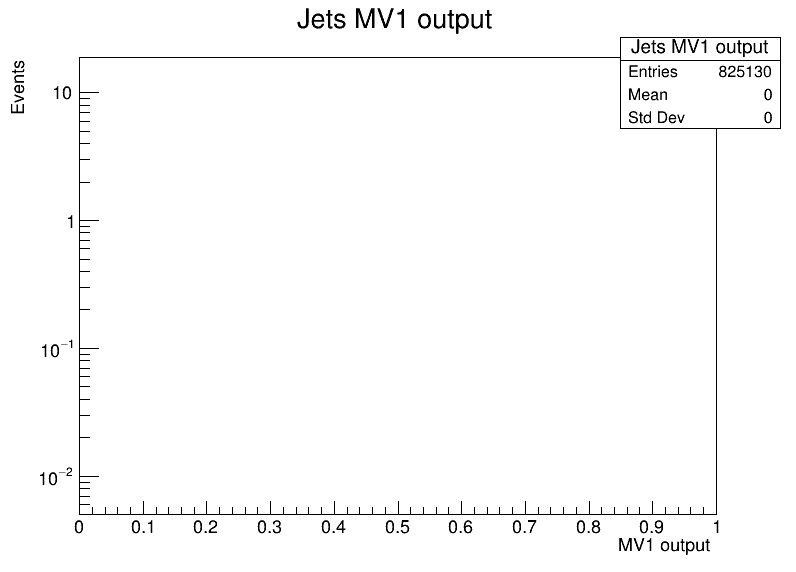

In [16]:
hist_jets_MV1->Draw();
canvas->Draw();

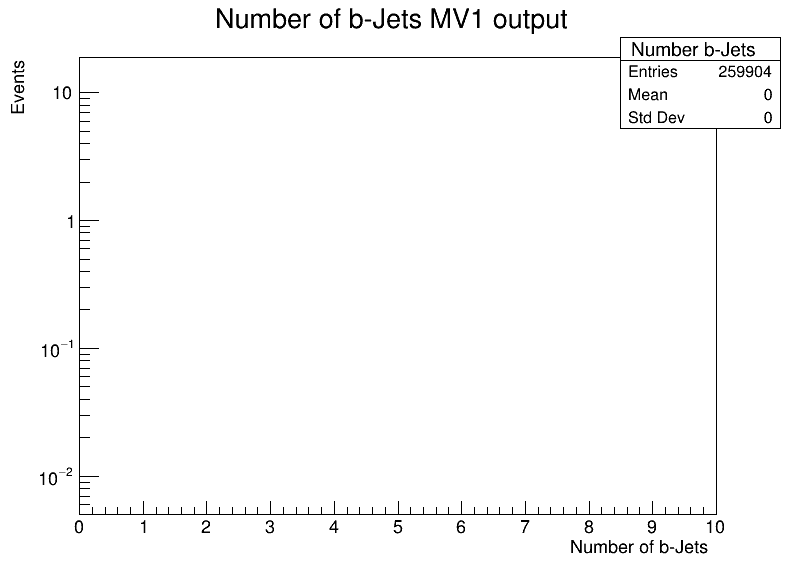

In [17]:
hist_n_bjets->Draw();
canvas->Draw();

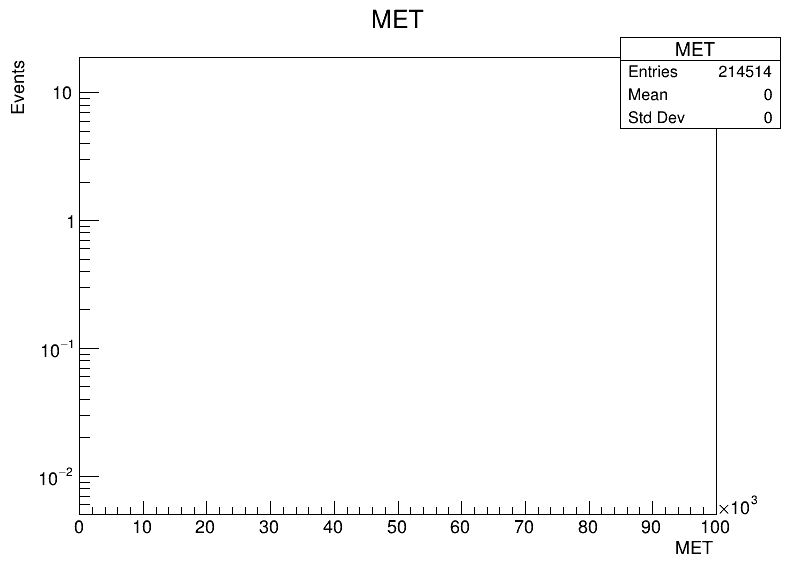

In [18]:
hist_MET->Draw();
canvas->Draw();

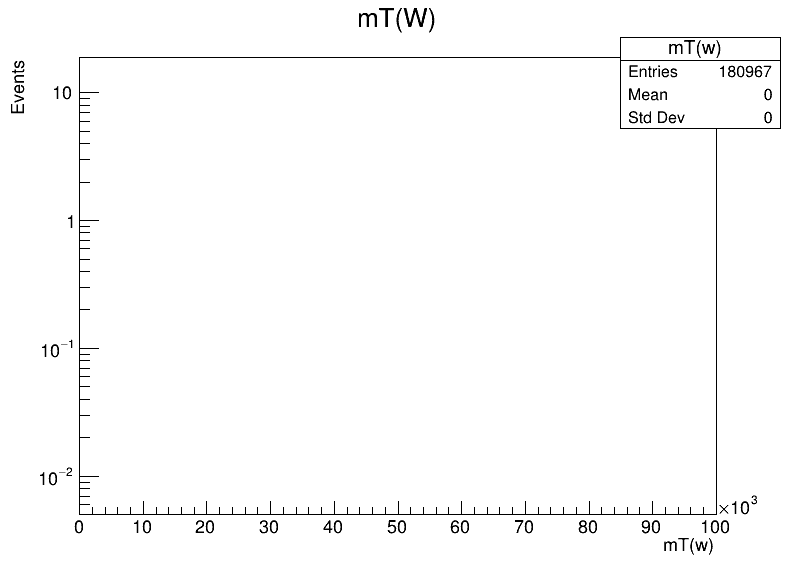

In [19]:
hist_MTW->Draw();
canvas->Draw();